In [8]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import nolearn
from nolearn.lasagne import NeuralNet
from progress_bar import ProgressBar
import createdbx as cdb
import lasagne
from lasagne import layers
from sklearn import metrics
import detectobjects as det
import cv2

Populating the interactive namespace from numpy and matplotlib



In [9]:
opts = {'img_dir': '/home/rose/Documents/william_PGDCSC_project_24_5_2017/data/intestinalparasites-phonecamera_19_5_2017/',
        'models_dir': '../models/',
        'annotation_dir': '/home/rose/Documents/william_PGDCSC_project_24_5_2017/data/intestinalparasites-phonecamera_19_5_2017/',
        'train-dir': '/home/rose/Documents/project_tb/train_dir/',
        'test-dir': '/home/rose/Documents/project_tb/test_dir/',
        'val-dir': '/home/rose/Documents/project_tb/val_dir/',
        'patches_dir': '/home/rose/Documents/project_tb/patches_dir/',
        
        'augment-training-data': False,
        'model': '2C-1FC-O',
        'threshold': 0.9, 
        'overlapThreshold': 0.3, 
        'lim': 0, 
        'gauss': 1,
        'prob': det.non_maximum_suppression, 
        'pos': det.non_maximum_suppression, 
#         'prob': det.MAX, 
#         'pos': det.MAX, 
        'probs_area': 90,
        'input_scale': None,
        'raw_scale': 255,
        'image_dims': (160,160),
        'image_downsample' : 8,
        'patch_stride_training' : 40,
        'channel_swap': None,
        'probs_area': 40,
        'detection-step': 15,
        'patch-creation-step': 40,
       }

In [10]:
trainfiles, valfiles, testfiles = cdb.create_sets(opts['img_dir'], train_set_proportion=.7, 
                                                  test_set_proportion=.29,
                                                  val_set_proportion=.01)

train_y, train_X = cdb.create_patches_at_center(trainfiles, opts['annotation_dir'], opts['img_dir'], opts['image_dims'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'])
test_y, test_X = cdb.create_patches_at_center(testfiles,  opts['annotation_dir'], opts['img_dir'], opts['image_dims'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'])
val_y, val_X = cdb.create_patches_at_center(valfiles, opts['annotation_dir'], opts['img_dir'], opts['image_dims'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'])

# For training/validation, cut down on disproportionately large numbers of negative patches
train_X, train_y = cdb.balance(train_X, train_y, mult_neg=100)
val_X, val_y = cdb.balance(val_X, val_y, mult_neg=100)

# Create rotated and flipped versions of the positive patches
train_X, train_y = cdb.augment_positives(train_X, train_y)
val_X, val_y = cdb.augment_positives(val_X, val_y)
test_X, test_y = cdb.augment_positives(test_X, test_y)


[****************100%******************]  13 of 13 completete                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

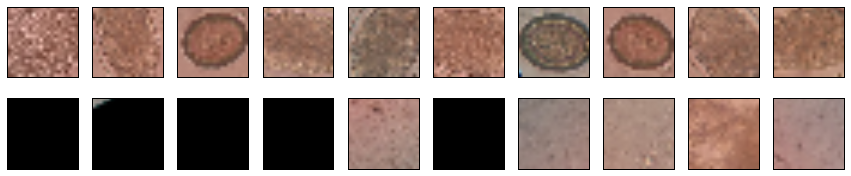

In [15]:
N_samples_to_display = 10
pos_indices = np.where(train_y)[0]
pos_indices = pos_indices[np.random.permutation(len(pos_indices))]
for i in range(N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_pos = train_X[pos_indices[i],:,:,:]
    example_pos = np.swapaxes(example_pos,0,2)
    plt.imshow(example_pos[:,:,[2,1,0]])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

neg_indices = np.where(train_y==0)[0]
neg_indices = neg_indices[np.random.permutation(len(neg_indices))]
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = train_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.gcf().set_size_inches(1.5*N_samples_to_display,3)

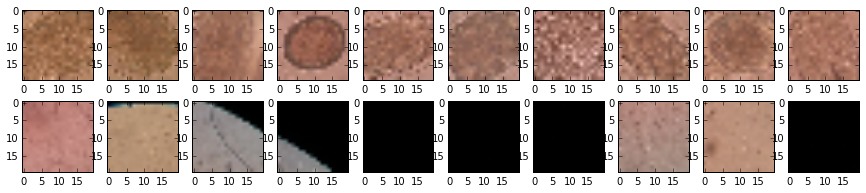

In [16]:
N_samples_to_display = 10
pos_indices = np.where(train_y)[0]
pos_indices = pos_indices[np.random.permutation(len(pos_indices))]
for i in range(N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_pos = train_X[pos_indices[i],:,:,:]
    example_pos = np.swapaxes(example_pos,0,2)
    plt.imshow(example_pos[:,:,[2,1,0]])
    
neg_indices = np.where(train_y==0)[0]
neg_indices = neg_indices[np.random.permutation(len(neg_indices))]
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = train_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])
    
plt.gcf().set_size_inches(1.5*N_samples_to_display,3)

In [17]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['image_dims'][0]/opts['image_downsample'], 
                 opts['image_dims'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden3_num_units=100,
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(50).fit(train_X, train_y)

# Neural Network with 77646 learnable parameters

## Layer information

  #  name     size
---  -------  -------
  0  input    3x20x20
  1  conv1    7x18x18
  2  pool1    7x9x9
  3  conv2    12x8x8
  4  hidden3  100
  5  output   2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.58808       0.31703      5.00922      0.94336  2.97s
      2       0.26459       0.26834      0.98601      0.95742  3.07s
      3       0.21078       0.22570      0.93389      0.96628  3.05s
      4       0.17451       0.19269      0.90563      0.96901  3.02s
      5       0.14596       0.16719      0.87306      0.96849  2.83s
      6       0.12266       0.14638      0.83793      0.96888  2.73s
      7       0.10455       0.13107      0.79768      0.97122  2.70s
      8       0.09071       0.12189      0.74413      0.97148  2.71s
      9       0.08011       0.11314      0.70810      0.97188  2.72s
     10   

In [18]:
y_pred = cnn.predict_proba(test_X)

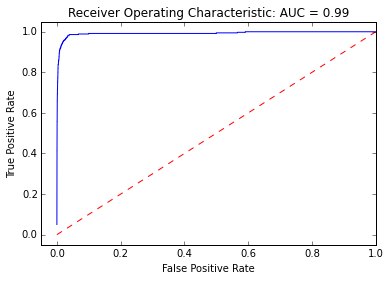

In [19]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

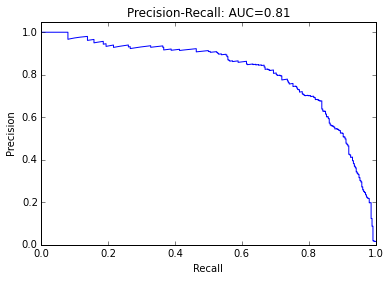

In [20]:
precision, recall, thresholds = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision = metrics.average_precision_score(test_y, y_pred[:, 1])

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

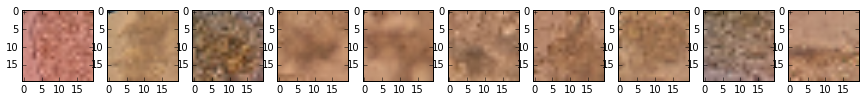

In [21]:
neg_indices = np.where(test_y==0)[0]
neg_scores = y_pred[neg_indices,1]
neg_indices = neg_indices[neg_scores.argsort()]
neg_indices = neg_indices[::-1]

neg_scores = y_pred[neg_indices,1]
neg_scores

N_samples_to_display = 10

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

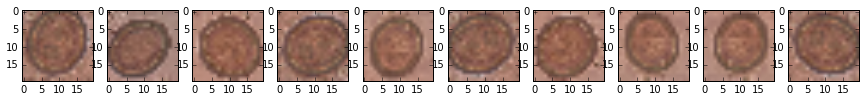

In [22]:
prob_range = [.9,1.]

tmp_scores = y_pred.copy()[:,1]
tmp_scores[tmp_scores<prob_range[0]] = -1
tmp_scores[tmp_scores>prob_range[1]] = -1

pos_indices = tmp_scores.argsort()
pos_indices = pos_indices[::-1]

N_samples_to_display = 10

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

In [29]:
tmp_scores[pos_indices[i]]

-1.0

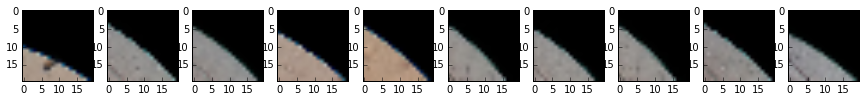

In [23]:
pos_indices = y_pred[:,1].argsort()
#pos_indices = pos_indices[::-1]

N_samples_to_display = 10

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

In [62]:
import detectobjectsy as det1

In [73]:
imfile = opts['img_dir'] + testfiles[12]
opts['threshold'] = 0.99
found = det1.detect(imfile, cnn, opts)
found

array([], dtype=float64)

In [74]:
testfiles[12]

'intestinalparasites-phone-0785.jpg'

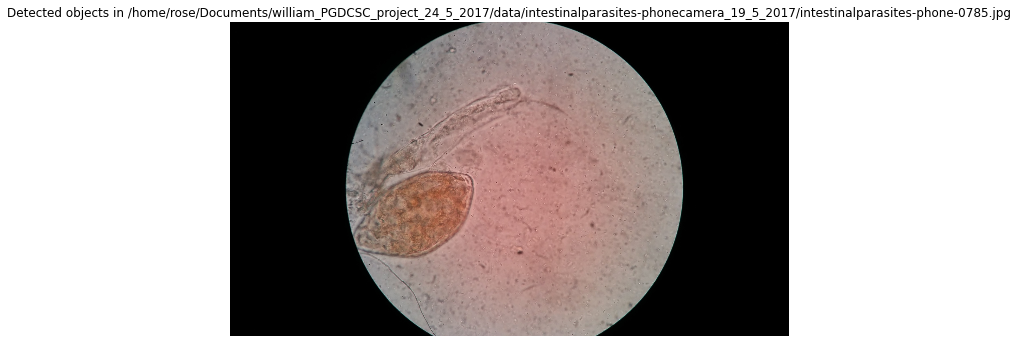

In [75]:
import cv2
im = cv2.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

for f in det1.detect(imfile, cnn, opts):
    f = f.astype(int)
    
    cv2.rectangle(im, (f[0], f[1]), (f[2],f[3]), (0,0,255), 8)
    
plt.gcf().set_size_inches(10,10)
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im[:,:,[2,1,0]])

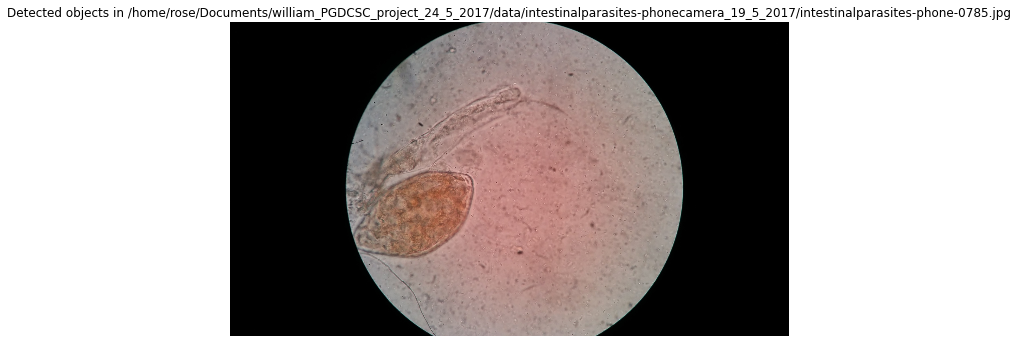

In [76]:
import cv2
im = cv2.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

for f in found:
    f = f.astype(int)
    cv2.rectangle(im, (f[0], f[1]), (f[2],f[3]), (0,0,255), 8)
    
plt.gcf().set_size_inches(10,10)
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im[:,:,[2,1,0]])